In [59]:
# This is a guided project.
# Import the necessary packages
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint


In [60]:
facialpoints_df = pd.read_csv('KeyFacialPoints.csv')
facialpoints_df
facialpoints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [61]:
invalid_rows = facialpoints_df['Image'].apply(lambda x: len(np.fromstring(x, dtype=int, sep=' ')) != 9216)
print("Invalid rows found:\n", facialpoints_df[invalid_rows])
facialpoints_df = facialpoints_df[~invalid_rows]
facialpoints_df['Image'] = facialpoints_df['Image'].apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape(96, 96))

Invalid rows found:
 Empty DataFrame
Columns: [left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, nose_tip_x, nose_tip_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y, Image]
Index: []

[0 rows x 31 columns]


In [62]:
#checking the shape here
facialpoints_df['Image'][1].shape

(96, 96)

In [63]:
#checking null values
facialpoints_df.isna().sum()

,0
left_eye_center_x,0
left_eye_center_y,0
right_eye_center_x,0
right_eye_center_y,0
left_eye_inner_corner_x,0
left_eye_inner_corner_y,0
left_eye_outer_corner_x,0
left_eye_outer_corner_y,0
right_eye_inner_corner_x,0
right_eye_inner_corner_y,0


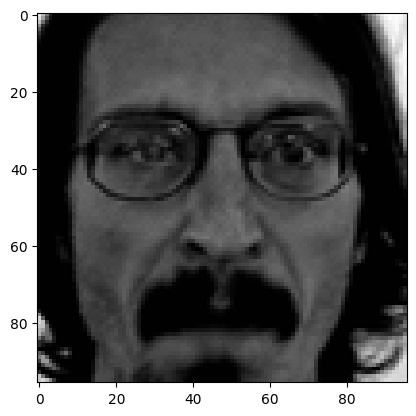

In [64]:
#Performing image visualisation here onwards
#starting with plotting a random image
i = np.random.randint(0, len(facialpoints_df) - 1)
plt.imshow(facialpoints_df['Image'].iloc[i], cmap='gray')

<ipython-input-65-caacb499972a>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(facialpoints_df.loc[i][j-1], facialpoints_df.loc[i][j], 'rx')


<Figure size 640x480 with 0 Axes>

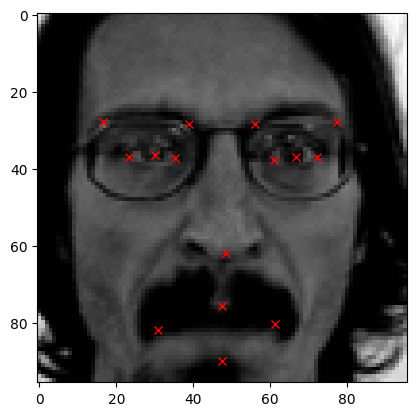

In [65]:
#The (x, y) coordinates for the 15 key features are plotted on top of the image using a for loop that iterates from index 1 to 32 with a step of 2. In each iteration, j takes on values like 1, 3, 5, etc.
#The x-coordinates are in even columns (0, 2, 4, ...) and the y-coordinates are in odd columns (1, 3, 5, ...). We use the .loc command to access the values for these coordinates based on the current index.
#For example, in the first iteration, df.loc[i][j-1] accesses the x-coordinate in column 0 of row i, corresponding to the image's x-coordinate for that feature.
plt.figure()
plt.figure()
plt.imshow(facialpoints_df['Image'][i],cmap='gray')
for j in range(1,31,2):
        plt.plot(facialpoints_df.loc[i][j-1], facialpoints_df.loc[i][j], 'rx')

<ipython-input-66-b35e603a410e>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(facialpoints_df.loc[i][j-1], facialpoints_df.loc[i][j], 'rx')


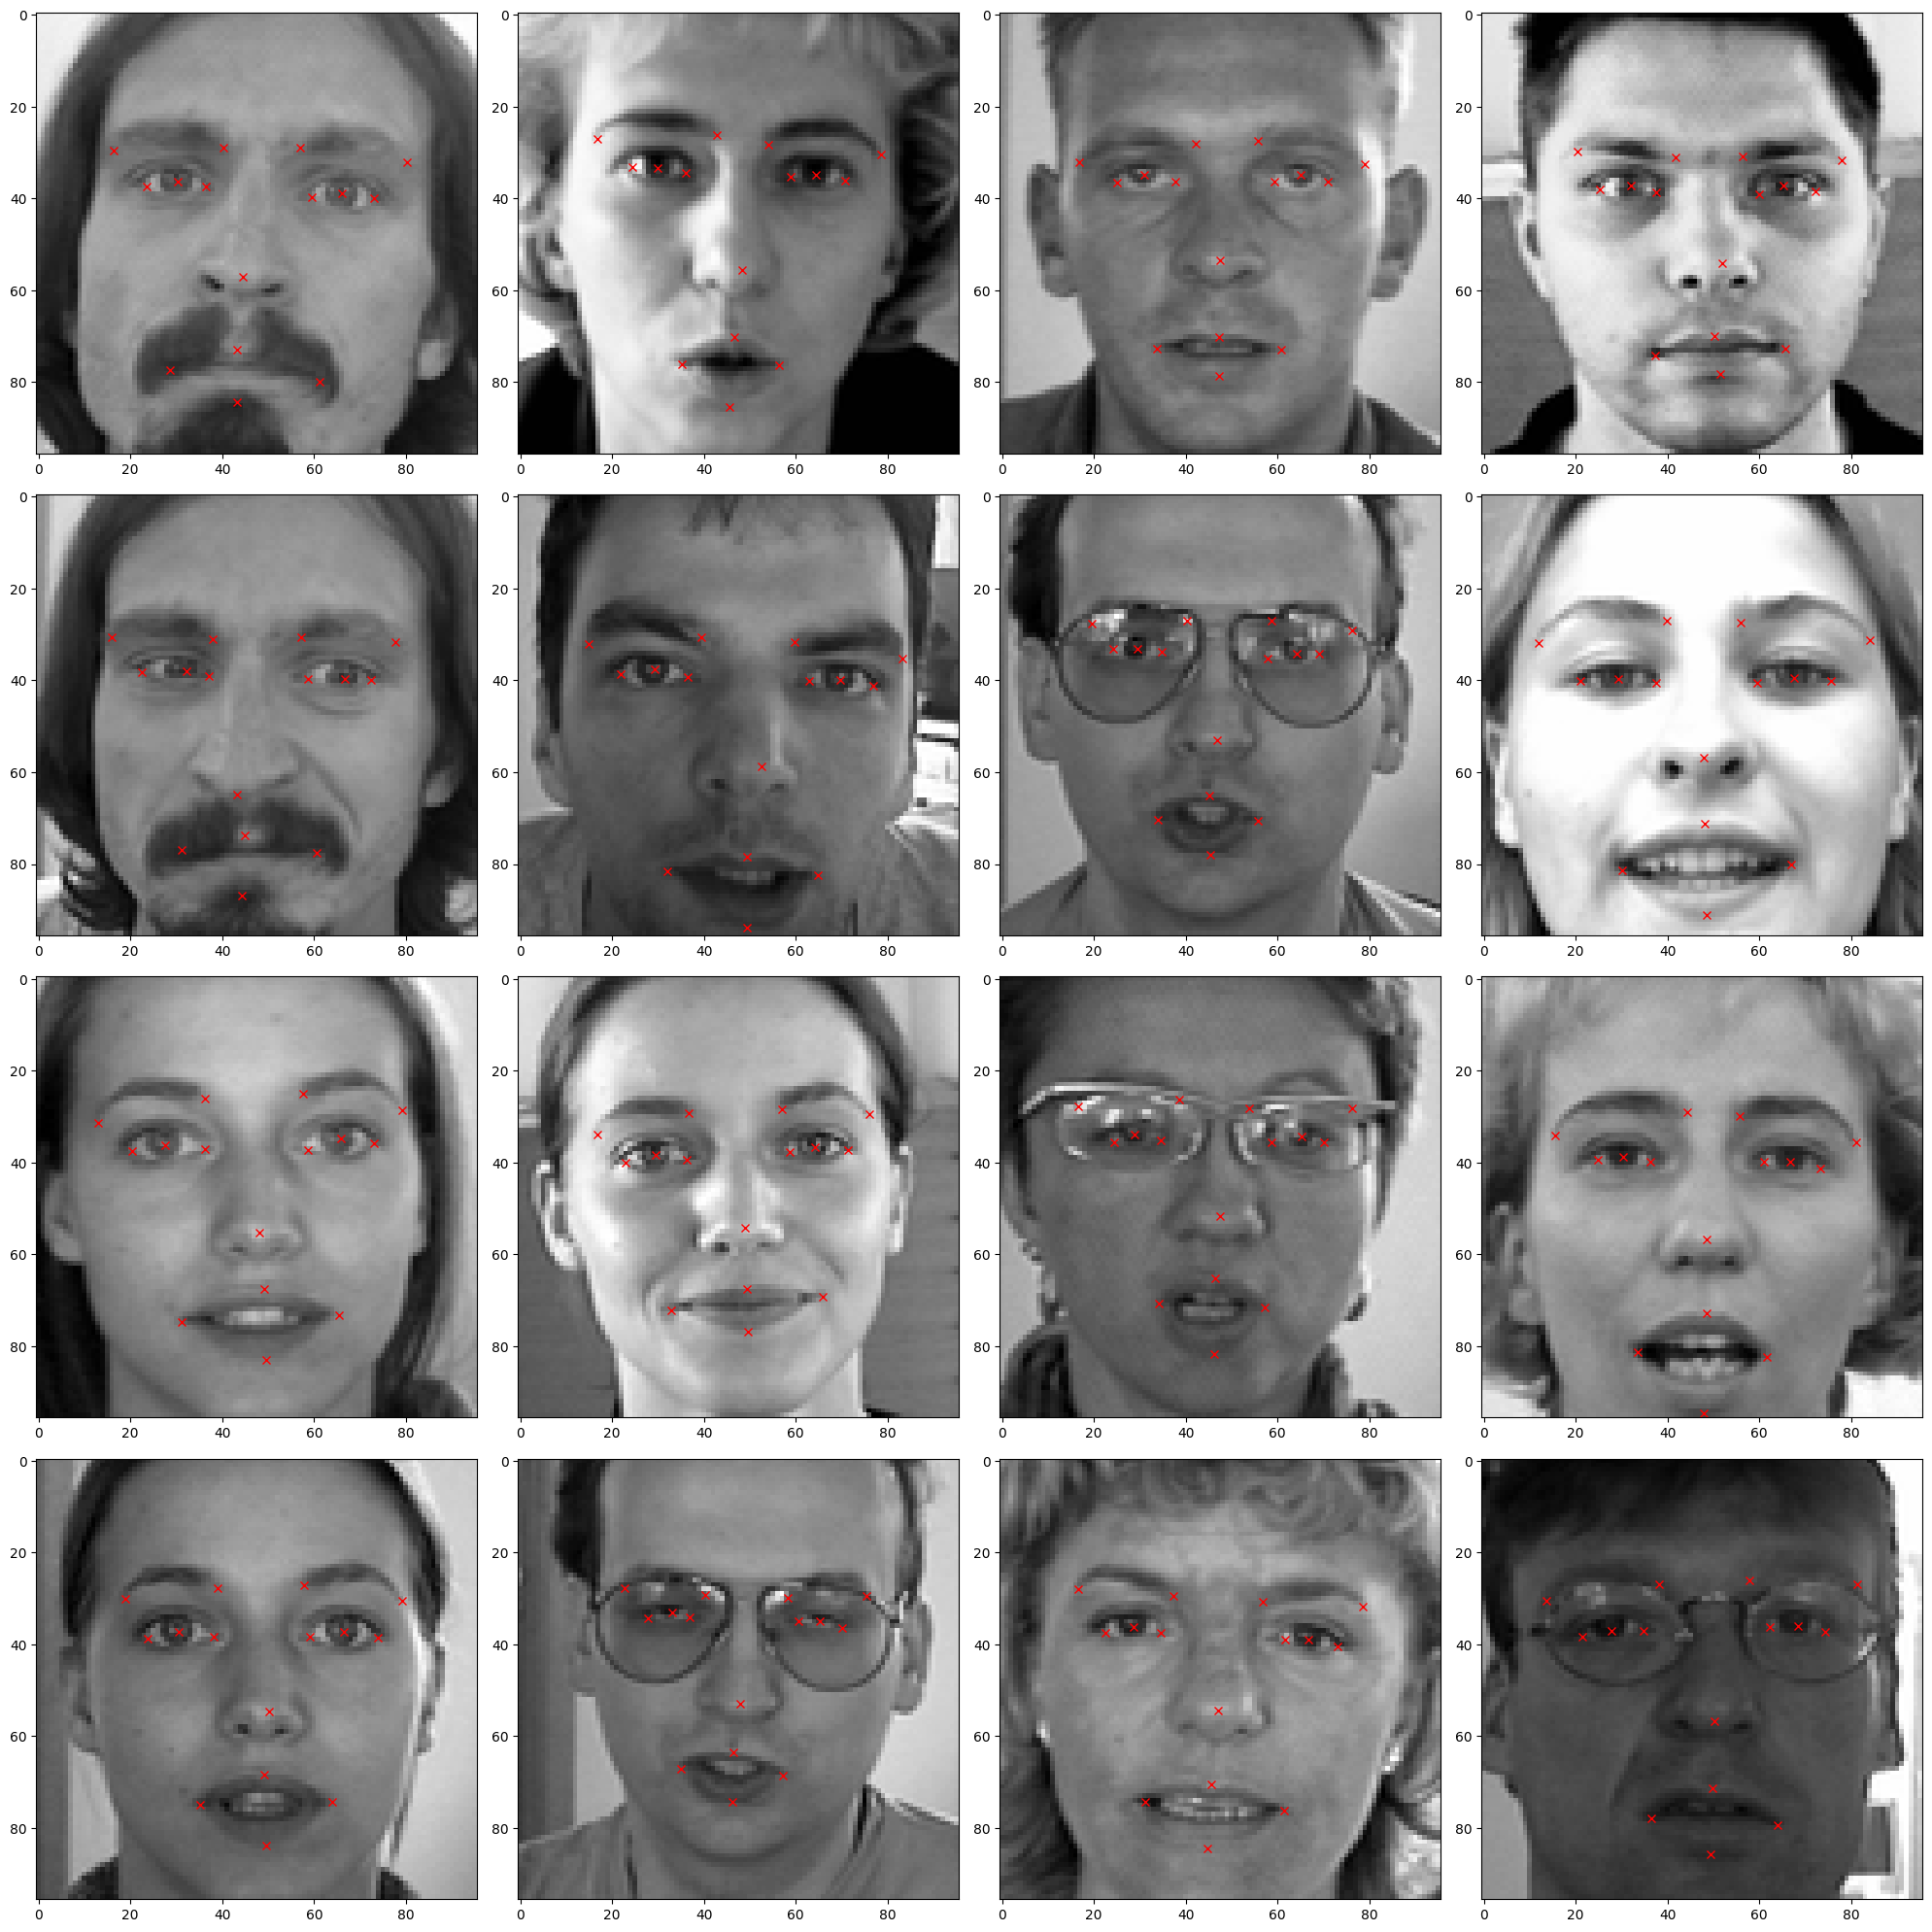

In [66]:
#viewing the grid format
fig = plt.figure(figsize=(20, 20))
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1) #this is 4 by 4 grid
    image = ax.imshow(facialpoints_df['Image'][i], cmap='gray')

#The keypoints here=red cross
    for j in range(1, 31, 2):
        ax.plot(facialpoints_df.loc[i][j-1], facialpoints_df.loc[i][j], 'rx')

plt.tight_layout()
plt.show()


In [67]:
#viewing and checking stats
facialpoints_df.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,...,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000
mean,66.221549,36.842274,29.640269,37.063815,59.272128,37.856014,73.412473,37.640110,36.603107,37.920852,...,47.952141,57.253926,63.419076,75.887660,32.967365,76.134065,48.081325,72.681125,48.149654,82.630412
std,2.087683,2.294027,2.051575,2.234334,2.005631,2.034500,2.701639,2.684162,1.822784,2.009505,...,3.276053,4.528635,3.650131,4.438565,3.595103,4.259514,2.723274,5.108675,3.032389,4.813557
min,47.835757,23.832996,18.922611,24.773072,41.779381,27.190098,52.947144,26.250023,24.112624,26.250023,...,24.472590,41.558400,43.869480,57.023258,9.778137,56.690208,32.260312,56.719043,33.047605,57.232296
25%,65.046300,35.468842,28.472224,35.818377,58.113054,36.607950,71.741978,36.102409,35.495730,36.766783,...,46.495330,54.466000,61.341291,72.874263,30.879288,73.280038,46.580004,69.271669,46.492000,79.417480
50%,66.129065,36.913319,29.655440,37.048085,59.327154,37.845220,73.240045,37.624207,36.620735,37.920336,...,47.900511,57.638582,63.199057,75.682465,33.034022,75.941985,47.939031,72.395978,47.980854,82.388899
75%,67.332093,38.286438,30.858673,38.333884,60.521492,39.195431,74.978684,39.308331,37.665280,39.143921,...,49.260657,60.303524,65.302398,78.774969,35.063575,78.884031,49.290000,75.840286,49.551936,85.697976
max,78.013082,46.132421,42.495172,45.980981,69.023030,47.190316,87.032252,49.653825,47.293746,44.887301,...,65.279654,75.992731,84.767123,94.673637,50.973348,93.443176,61.804506,93.916338,62.438095,95.808983


In [68]:
#Performing image augmentation here onwards
import copy
facialpoints_df_copy = copy.copy(facialpoints_df)

In [69]:
#obtaining column names
columns = facialpoints_df_copy.iloc[:, :-1].columns
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [70]:
#flipping the image horizontally
for index, image in enumerate(facialpoints_df_copy['Image']):
    facialpoints_df_copy.at[index, 'Image'] = np.flip(image, axis=1)

In [71]:
#witnessing that the pixels for the image are now flipped as well.
facialpoints_df_copy['Image'][0]

array([[250, 250, 250, ..., 237, 236, 238],
       [251, 250, 249, ..., 236, 238, 235],
       [250, 251, 251, ..., 237, 236, 237],
       ...,
       [ 60,  57,  52, ..., 181, 183, 186],
       [ 78,  69,  61, ..., 207, 188, 189],
       [ 90,  75,  70, ..., 184, 184, 191]])

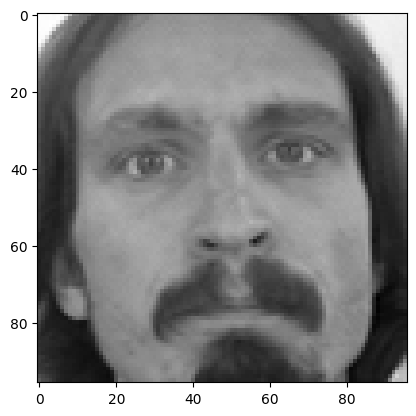

In [72]:
plt.imshow(facialpoints_df_copy['Image'][0], cmap = 'gray')

In [73]:
# When flipping images horizontally, the y-coordinate values remain unchanged.
# To update the x-coordinate values, we need to subtract each initial x-coordinate from the image's width.
for i, column in enumerate(columns):
    if i % 2 == 0:
        facialpoints_df_copy[column] = facialpoints_df_copy[column].apply(lambda x: 96. - float(x))

<ipython-input-74-9b7c018b6470>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(facialpoints_df.loc[0][j - 1], facialpoints_df.loc[0][j], 'rx')


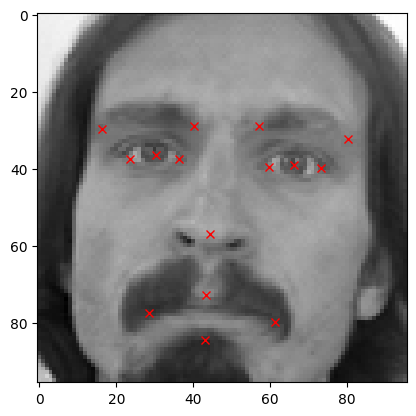

In [74]:
#original
plt.imshow(facialpoints_df['Image'][0], cmap='gray')
for j in range(1, 31, 2):
    plt.plot(facialpoints_df.loc[0][j - 1], facialpoints_df.loc[0][j], 'rx')

<ipython-input-75-750c4a1cac01>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(facialpoints_df_copy.loc[0][j - 1], facialpoints_df_copy.loc[0][j], 'rx')


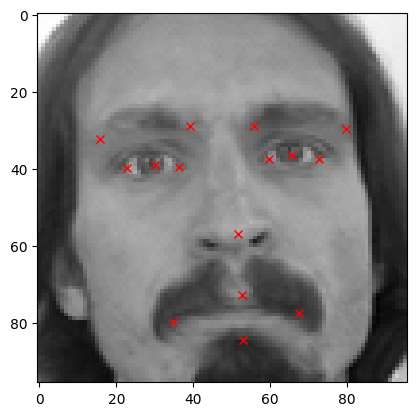

In [75]:
#flipped
plt.imshow(facialpoints_df_copy['Image'][0], cmap='gray')
for j in range(1, 31, 2):
    plt.plot(facialpoints_df_copy.loc[0][j - 1], facialpoints_df_copy.loc[0][j], 'rx')

In [76]:
#concatenating
facialpoints_df_augmented = np.concatenate((facialpoints_df,facialpoints_df_copy))

In [77]:
#augmented shape is as follows
facialpoints_df_augmented.shape

(4280, 31)

In [78]:
import random
facialpoints_df_copy = copy.copy(facialpoints_df)
facialpoints_df_copy['Image'] = facialpoints_df['Image'].apply(lambda x: np.clip(random.uniform(1, 2) * x, 0.0, 255.0))
facialpoints_df_augmented = np.concatenate((facialpoints_df_augmented, facialpoints_df_copy))
facialpoints_df_augmented.shape

(6420, 31)

In [79]:
#performing image augmentation by decreasing image brightness
facialpoints_df_copy = facialpoints_df.copy()
facialpoints_df_copy['Image'] = facialpoints_df['Image'].map(lambda x: np.clip(random.uniform(0, 0.2) * x, 0.0, 255.0))

<ipython-input-80-c33e1ec0b073>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(facialpoints_df_copy.loc[0][j-1], facialpoints_df_copy.loc[0][j], 'rx')


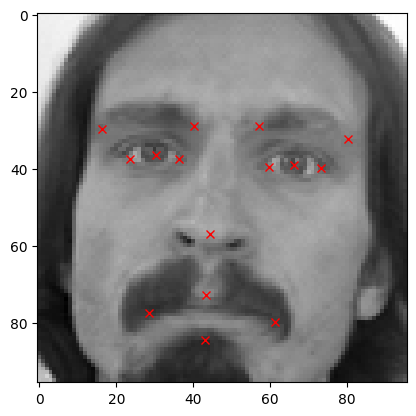

In [80]:
#viewing sample image
plt.imshow(facialpoints_df_copy['Image'][0], cmap = 'gray')
for j in range(1,31,2):
        plt.plot(facialpoints_df_copy.loc[0][j-1], facialpoints_df_copy.loc[0][j], 'rx')

In [81]:
#augmenting images by flipping them
facialpoints_df_copy = copy.copy(facialpoints_df)

In [82]:
facialpoints_df_copy['Image'] = facialpoints_df_copy['Image'].apply(lambda x: np.flip(x, axis = 0))

In [83]:
#stated earlier
for i in range(len(columns)):
  if i%2 == 1:
    facialpoints_df_copy[columns[i]] = facialpoints_df_copy[columns[i]].apply(lambda x: 96. - float(x) )

<ipython-input-84-fb4971913384>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(facialpoints_df_copy.loc[0][j-1], facialpoints_df_copy.loc[0][j], 'rx')


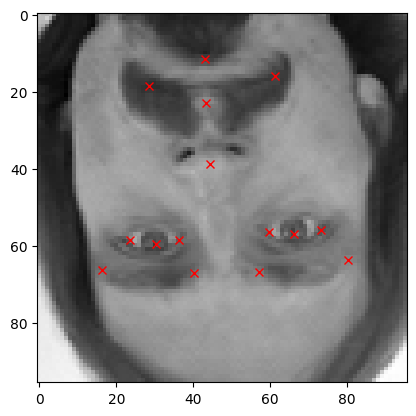

In [84]:
#viewing flipped image
plt.imshow(facialpoints_df_copy['Image'][0], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(facialpoints_df_copy.loc[0][j-1], facialpoints_df_copy.loc[0][j], 'rx')

In [85]:
#Normalisation and data training
img = facialpoints_df_augmented[:, 30] / 255.0
X = np.empty((len(img), 96, 96, 1))
for i in range(len(img)):
    X[i] = np.expand_dims(img[i], axis=2)
X = X.astype(np.float32)
X.shape

(6420, 96, 96, 1)

In [86]:
#obtaining coordinates
y = facialpoints_df_augmented[:, :30]
y = y.astype(np.float32)
y.shape

(6420, 30)

In [87]:
#splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [88]:
#Now building deep residual neural network models

def res_block(X, filters, stage):
    # Unpack filters
    f1, f2, f3 = filters

    #original input for the shortcut path
    X_shortcut = X

    # This is the Convolutional Block
    # Main Path
    X = Conv2D(f1, (1, 1), strides=(1, 1), name=f'res_{stage}_conv_a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = MaxPool2D((2, 2))(X)
    X = BatchNormalization(axis=3, name=f'bn_{stage}_conv_a')(X)
    X = Activation('relu')(X)
    X = Conv2D(f2, (3, 3), strides=(1, 1), padding='same', name=f'res_{stage}_conv_b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=f'bn_{stage}_conv_b')(X)
    X = Activation('relu')(X)
    X = Conv2D(f3, (1, 1), strides=(1, 1), name=f'res_{stage}_conv_c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=f'bn_{stage}_conv_c')(X)

    # Shortcut Path
    X_shortcut = Conv2D(f3, (1, 1), strides=(1, 1), name=f'res_{stage}_conv_shortcut', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = MaxPool2D((2, 2))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=f'bn_{stage}_conv_shortcut')(X_shortcut)

    # Combining main path and shortcut path
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    # Block1
    X_shortcut = X

    # Main Path
    X = Conv2D(f1, (1, 1), strides=(1, 1), name=f'res_{stage}_identity_1_a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=f'bn_{stage}_identity_1_a')(X)
    X = Activation('relu')(X)
    X = Conv2D(f2, (3, 3), strides=(1, 1), padding='same', name=f'res_{stage}_identity_1_b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=f'bn_{stage}_identity_1_b')(X)
    X = Activation('relu')(X)
    X = Conv2D(f3, (1, 1), strides=(1, 1), name=f'res_{stage}_identity_1_c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=f'bn_{stage}_identity_1_c')(X)

    # Combining main path and shortcut path
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    # Block2
    X_shortcut = X

    # Main Path
    X = Conv2D(f1, (1, 1), strides=(1, 1), name=f'res_{stage}_identity_2_a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=f'bn_{stage}_identity_2_a')(X)
    X = Activation('relu')(X)
    X = Conv2D(f2, (3, 3), strides=(1, 1), padding='same', name=f'res_{stage}_identity_2_b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=f'bn_{stage}_identity_2_b')(X)
    X = Activation('relu')(X)
    X = Conv2D(f3, (1, 1), strides=(1, 1), name=f'res_{stage}_identity_2_c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=f'bn_{stage}_identity_2_c')(X)
    # Combining main path and shortcut path
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


In [89]:
input_shape = (96, 96, 1)
X_input = Input(shape=input_shape)

#retain spatial dimension
X = ZeroPadding2D(padding=(3, 3))(X_input)

# Stage 1
X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(X)

# Stage 2
X = res_block(X, filters=[64, 64, 256], stage=2)

# Stage 3
X = res_block(X, filters=[128, 128, 512], stage=3)


X = AveragePooling2D(pool_size=(2, 2), name='Average_Pooling')(X)

# Final layer sequence
X = Dense(30, activation='relu')(Dropout(0.1)(Dense(2048, activation='relu')(Dropout(0.2)(Dense(4096, activation='relu')(Flatten()(X))))))

# Model definition
model = Model(inputs=X_input, outputs=X)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 96, 96, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 102, 102, 1)    │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 48, 48, 64)     │          3,200 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_conv1                  │ (None, 48, 48, 64)     │            256 │ conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_19             │ (None, 48, 48, 64)     │              0 │ bn_conv1[0][0]         │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 23, 23, 64)     │              0 │ activation_19[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_2_conv_a (Conv2D)     │ (None, 23, 23, 64)     │          4,160 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 11, 11, 64)     │              0 │ res_2_conv_a[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_2_conv_a               │ (None, 11, 11, 64)     │            256 │ max_pooling2d_6[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 11, 11, 64)     │              0 │ bn_2_conv_a[0][0]      │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_2_conv_b (Conv2D)     │ (None, 11, 11, 64)     │         36,928 │ activation_20[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_2_conv_b               │ (None, 11, 11, 64)     │            256 │ res_2_conv_b[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_21             │ (None, 11, 11, 64)     │              0 │ bn_2_conv_b[0][0]      │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_2_conv_shortcut       │ (None, 23, 23, 256)    │         16,640 │ max_pooling2d_5[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 18,016,286 (68.73 MB)

 Trainable params: 18,007,710 (68.69 MB)

 Non-trainable params: 8,576 (33.50 KB)

In [90]:
#compile
adam = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="mean_squared_error", optimizer = adam, metrics = ['accuracy'])


In [99]:
checkpointer = ModelCheckpoint(filepath = "weights.keras", verbose = 1, save_best_only = True)

In [100]:
history = model.fit(X_train, y_train, batch_size = 256, epochs= 10, validation_split = 0.05, callbacks=[checkpointer])

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6139 - loss: 236.8662
Epoch 1: val_loss improved from inf to 823.72034, saving model to weights.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 152s 7s/step - accuracy: 0.6136 - loss: 236.8660 - val_accuracy: 0.7093 - val_loss: 823.7203
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6210 - loss: 224.0070
Epoch 2: val_loss improved from 823.72034 to 732.16235, saving model to weights.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 201s 7s/step - accuracy: 0.6207 - loss: 224.0343 - val_accuracy: 0.7093 - val_loss: 732.1624
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6237 - loss: 222.7443
Epoch 3: val_loss improved from 732.16235 to 699.17932, saving model to weights.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 207s 7s/step - accuracy: 0.6234 - loss: 222.7637 - val_accuracy: 0.7093 - val_loss: 699.1793
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6269 - loss: 223.6593
Epoch 4: val_loss improved from 699.17932 to 603

In [101]:
result = model.evaluate(X_test,y_test)
print("Accuracy : {}".format(result[1]))

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.7068 - loss: 528.8293
Accuracy : 0.704049825668335


In [102]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

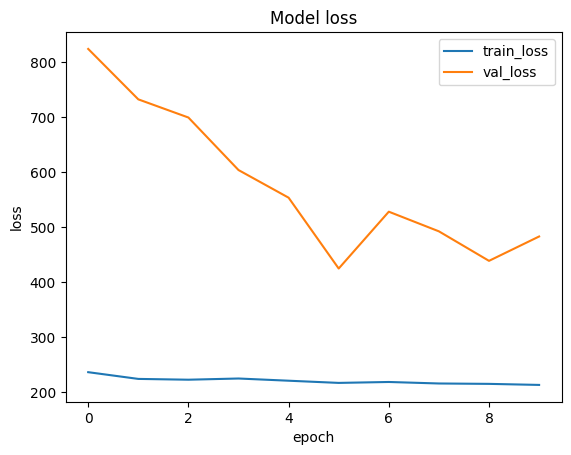

In [103]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

In [104]:
df_predict = model.predict(X_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 314ms/step


In [105]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_test, df_predict))
print("RMSE value : {}".format(rms))

RMSE value : 22.55810504070197


In [106]:
df_predict= pd.DataFrame(df_predict, columns = columns)
df_predict.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,33.226101,34.592087,53.652275,33.278435,37.691738,34.642090,30.223679,35.005367,50.139301,34.071323,...,45.556499,51.614197,35.203041,69.636681,52.208698,0.0,44.193409,66.052086,44.168072,75.342964
1,28.677256,34.610390,60.458706,34.042885,35.123379,34.858883,23.648970,35.834999,54.844730,34.596298,...,45.723980,51.393898,32.158989,70.554543,57.169830,0.0,44.946793,65.627228,44.649624,77.325134
2,30.019361,35.450619,62.214321,35.524952,36.408905,36.340233,25.103233,36.323902,56.731037,36.047829,...,47.836956,54.246597,33.587662,73.153130,59.130890,0.0,47.022488,69.763145,46.550774,78.808441
3,30.881990,35.576817,61.211269,35.686989,37.325935,36.485241,26.364065,36.302464,56.113964,36.337177,...,47.486843,55.002323,34.147552,73.657097,58.437836,0.0,47.040169,70.768852,46.479301,78.852814
4,29.447172,34.456936,58.373016,33.633453,35.420410,34.648106,25.161774,35.359062,53.340160,34.149067,...,45.907463,51.188309,32.832237,69.833992,55.704414,0.0,44.755138,65.675117,44.477909,76.314186


<ipython-input-107-4dfc90f1c110>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')


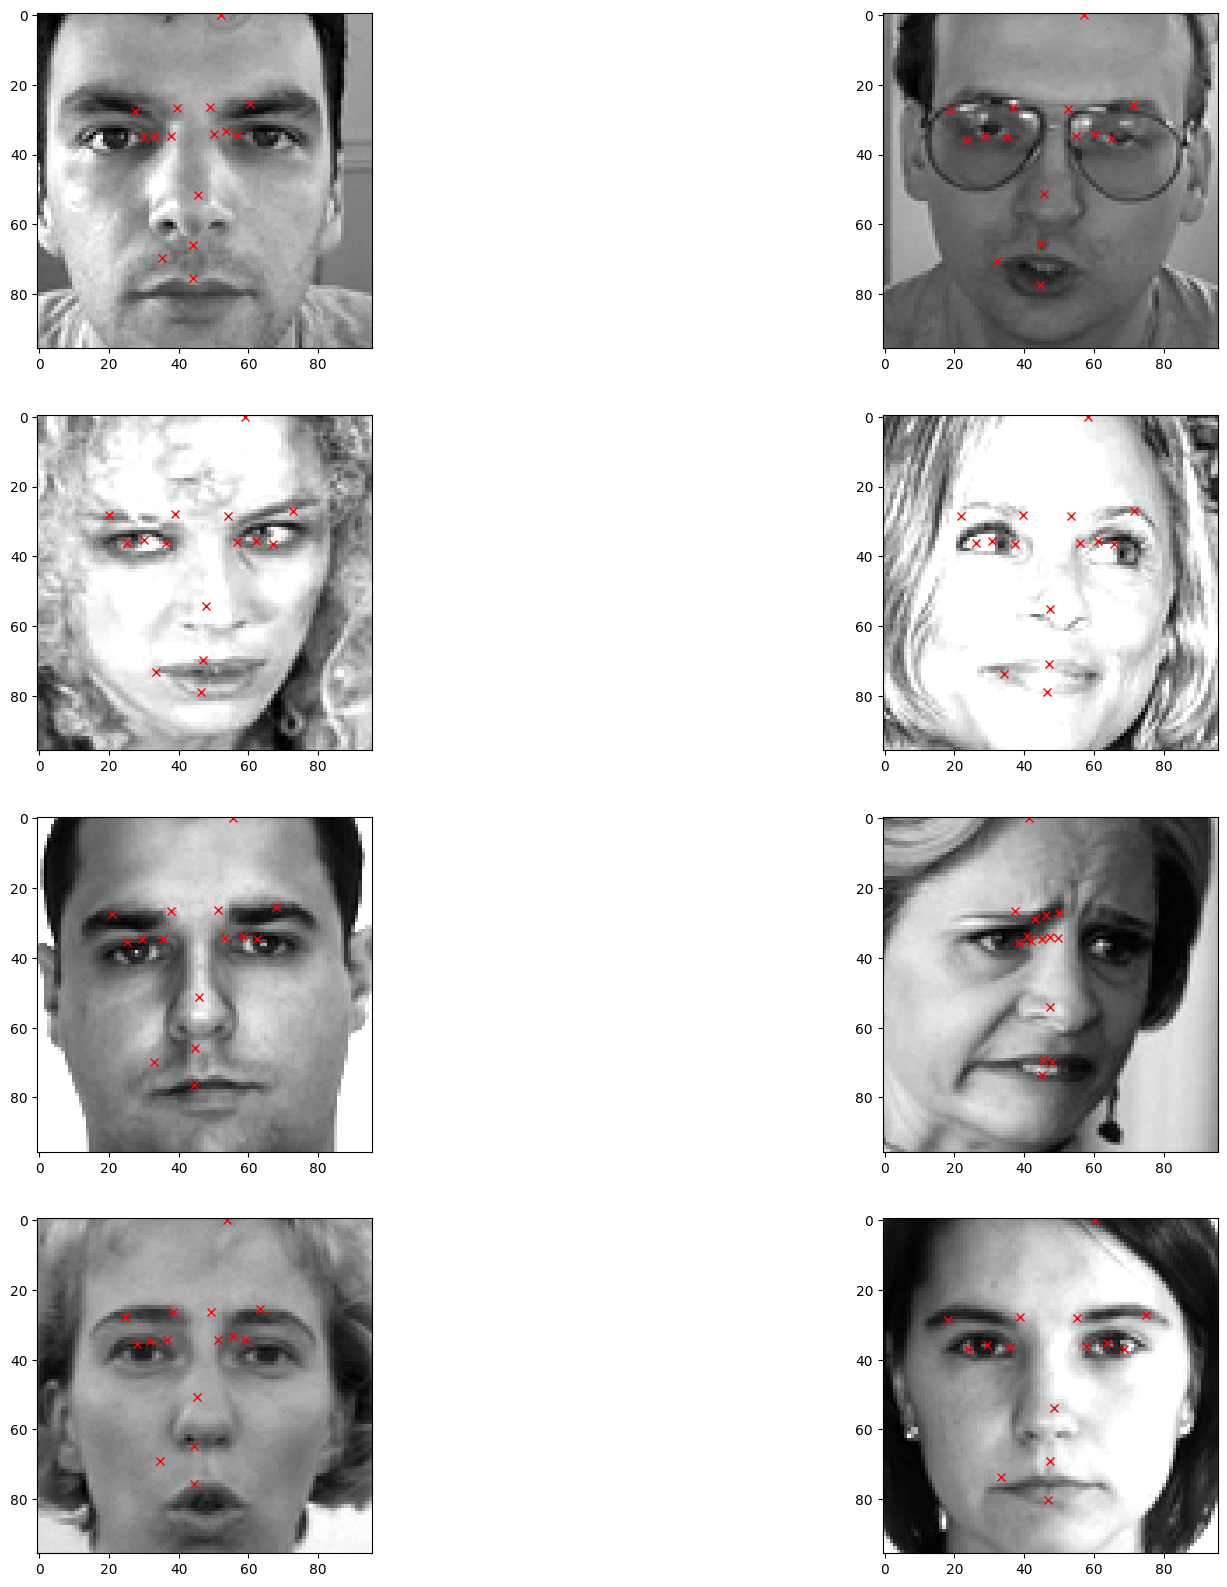

In [107]:
#Plotting
fig = plt.figure(figsize=(20, 20))

for i in range(8):
    ax = fig.add_subplot(4, 2, i + 1)
    # Using squeeze to convert the image shape from (96,96,1) to (96,96)
    plt.imshow(X_test[i].squeeze(),cmap='gray')
    for j in range(1,31,2):
            plt.plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')